In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader,Dataset
#import torchvision.datasets.ImageFolder 
import matplotlib.pyplot as plt
import numpy as np
import os
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size=4


# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        #print(f"image path: {img_path}")
        image = read_image(img_path)
        image=image.to(torch.float32)
        #print(f"image type: {type(image)}")
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            #print('here')
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
train_dataset= torchvision.datasets.ImageFolder("images",transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
#                                           shuffle=True)# # CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
# train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)

# test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
#                                           shuffle=True)

# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
#                                          shuffle=False)




In [12]:

class ConvNet(nn.Module):
    def __init__(self,output_size):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 2)
        self.fc1 = nn.Linear(20*1*16, 120)
        self.fc2 = nn.Linear(120, 50)
        self.fc3 = nn.Linear(50, output_size)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = F.relu(self.conv2(x))  # -> n, 16, 5, 5
        x = x.view(-1, 20*1*16)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x




In [17]:
output_size=10
model = ConvNet(output_size=10)
PATH=os.path.join("trained_models","28_12.pth")
model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
model.eval()

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)

In [18]:
#testing loaded model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(output_size)]
    n_class_samples = [0 for i in range(output_size)]
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 95.89201877934272 %


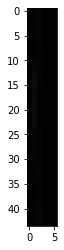

In [7]:
# Hyper-parameters 
output_size=10
print(device)
num_epochs = 1000
learning_rate = 0.001
model = ConvNet(output_size=output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(output_size)]
    n_class_samples = [0 for i in range(output_size)]
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')